## Electric Vehicle Price and Sales Tax Exemption

This notebook is an independent t-test analysis using electric vehicles (EVs) in the state of Washington from 1998 to 2019.

By Mike Galaviz

Data Source: Electric Vehicle Data from Department of Revenue Washington State. 
The data contains information for 62261 electric vehicles for model years 1993 to 2021 in Washington state.

According to the Washington Departmetn of Revenue, vehicles that can travel at least 30 miles on battery power alone qualify for a sales tax exemption up to 25,000 dollars of the price of a vehicle.

URL: https://data.wa.gov/Transportation/Electric-Vehicle-Population-Data/f6w7-q2d2

We're interested in the price of electric vehicles and how that impacts sales tax exemptions. The data contains information on over 62,000 EVs sold in Washington between 1998 to 2020. Because some (base manufactured retail price (MSRP) are missing, this analysis looks only at the years 2008 through 2020. We're interested in whether or not a car is eligible for the sales tax exemption and what the price of the EV is. Specifically, we're asking whether there is any difference in the mean price of cars that qualify and those that don't. 

This information may be useful to automakers and legislators alike. Automakers may adjust sales and marketed efforts if it turns out that the price of a car does not impact whether it qualifies for a tax exemption. Lawmakers may adjust tax policy on electric vehicles to either increase tax revenue or increase environmental sustainability efforts.

Our null hypothesis is that there is no difference in the median price between EVs that qualify and those that don't.
Our alternative hypothesis is that there is a significant difference between EVs that qualify and those that don't. 

The data reveals that both price (MSRP) and eligibility (yes or no) are both not normally distributed based on Q-Q plots. Instead of using a t-test on normally distributed data, we turn to the Mann-Whitney U test which is the nonparametric alternative t-test. 

In [63]:
import pandas as pd
import numpy as np

# pip install plotly
import plotly.graph_objects as go
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats

%matplotlib inline

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
pytest-cov 2.10.1 has requirement pytest>=4.6, but you'll have pytest 3.8.0 which is incompatible.
You are using pip version 10.0.1, however version 20.3b1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
df = pd.read_csv('Electric_Vehicle_Population_Data.csv')
df.head()

,VIN (1-10),County,City,State,ZIP Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location
0,KNDCE3LG3L,King,RENTON,WA,98059,2020,KIA,NIRO,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,239,0,11.0,128569878,POINT (-122.132064 47.494834)
1,KNDCE3LG9K,King,SEATTLE,WA,98108,2019,KIA,NIRO ELECTRIC,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,239,38500,37.0,105987073,POINT (-122.31336800000001 47.54411)
2,KNDCC3LG5L,King,RENTON,WA,98057,2020,KIA,NIRO,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,239,0,37.0,114300301,POINT (-122.215501 47.476576)
3,1G1FY6S00K,Thurston,YELM,WA,98597,2019,CHEVROLET,BOLT,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,36620,2.0,113112303,POINT (-122.558621 46.888349)
4,1N4AZ0CP6F,Chelan,LEAVENWORTH,WA,98826,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,29010,12.0,330944169,POINT (-120.73040299999998 47.74993200000001)


In [3]:
# looking at number of columns and rows and data types for Electric Vehicle Type, CAFV and Base MSRP.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62261 entries, 0 to 62260
Data columns (total 15 columns):
VIN (1-10)                                           62261 non-null object
County                                               62260 non-null object
City                                                 62261 non-null object
State                                                62261 non-null object
ZIP Code                                             62261 non-null int64
Model Year                                           62261 non-null int64
Make                                                 62261 non-null object
Model                                                62261 non-null object
Electric Vehicle Type                                62261 non-null object
Clean Alternative Fuel Vehicle (CAFV) Eligibility    62261 non-null object
Electric Range                                       62261 non-null int64
Base MSRP                                            62261 non-null i

In [4]:
# changing columns names to remove spaces

df.columns = df.columns.str.replace(' ','_')

In [5]:
df.columns

Index(['VIN_(1-10)', 'County', 'City', 'State', 'ZIP_Code', 'Model_Year',
       'Make', 'Model', 'Electric_Vehicle_Type',
       'Clean_Alternative_Fuel_Vehicle_(CAFV)_Eligibility', 'Electric_Range',
       'Base_MSRP', 'Legislative_District', 'DOL_Vehicle_ID',
       'Vehicle_Location'],
      dtype='object')

In [6]:
# EV models that do not have a base price by model year
# there are 8542 vehicles that have a 0 for price in the Base_MSRP column

df.query('Base_MSRP==0')['Model_Year'].value_counts()

2020    7926
2019     524
2021      69
2000       7
2017       5
2011       3
2018       2
2002       2
1999       1
1998       1
1997       1
1993       1
Name: Model_Year, dtype: int64

In [7]:
# which models don't have a price listed

df.query('Base_MSRP==0')['Model'].value_counts()

MODEL 3              3457
MODEL Y              1892
BOLT EV               558
MODEL X               541
E-GOLF                459
MODEL S               338
PRIUS PRIME           236
Q5 E                  171
LEAF                  147
KONA                  128
NIRO                  104
COOPER                 62
CAYENNE                55
I-PACE                 55
OUTLANDER - PHEV       54
CLARITY                47
FUSION                 44
I3                     39
IONIQ                  31
RANGE ROVER SPORT      21
GLC-CLASS              20
AVIATOR                18
PANAMERA               16
RANGE ROVER            10
RANGER                  9
E-TRON SPORTBACK        6
S-CLASS                 4
SONATA                  3
500                     3
CITY                    3
S90 AWD PHEV            3
RAV4 EV                 2
BENTAYGA HYBRID         1
A8 E                    1
I8                      1
CARAVAN                 1
S-10 PICKUP             1
FORTWO                  1
Name: Model,

In [8]:
# removing 8542 cars without a price. 7926 of them are 2020 model years
# consider whether removing this many late model vehicles may bias a ttest. 

indexNames = df[ df['Base_MSRP'] == 0 ].index
df.drop(indexNames , inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53719 entries, 1 to 62260
Data columns (total 15 columns):
VIN_(1-10)                                           53719 non-null object
County                                               53718 non-null object
City                                                 53719 non-null object
State                                                53719 non-null object
ZIP_Code                                             53719 non-null int64
Model_Year                                           53719 non-null int64
Make                                                 53719 non-null object
Model                                                53719 non-null object
Electric_Vehicle_Type                                53719 non-null object
Clean_Alternative_Fuel_Vehicle_(CAFV)_Eligibility    53719 non-null object
Electric_Range                                       53719 non-null int64
Base_MSRP                                            53719 non-null i

In [61]:
df['Model_Year'].value_counts()

2018    13376
2019     9640
2017     8007
2016     6315
2015     5033
2013     4900
2014     3755
2012     1747
2011      880
2010       32
2008       23
2020       10
Name: Model_Year, dtype: int64

In [9]:
# removing 1 Porsche 918 Spyder as an outlier at $845,000

spyder = df[ df['Base_MSRP'] == 845000 ].index
df.drop(spyder , inplace=True)

df.describe()

,ZIP_Code,Model_Year,Electric_Range,Base_MSRP,Legislative_District,DOL_Vehicle_ID
count,53718.000000,53718.000000,53718.000000,53718.000000,53682.000000,5.371800e+04
mean,98218.700715,2016.460032,126.522488,41198.077646,30.216423,2.319248e+08
std,1558.537931,2.173616,85.305932,16543.912336,14.612259,1.277632e+08
min,320.000000,2008.000000,6.000000,22995.000000,1.000000,4.385000e+03
25%,98052.000000,2015.000000,47.000000,31635.000000,20.000000,1.357581e+08
50%,98118.000000,2017.000000,93.000000,35000.000000,34.000000,2.102105e+08
75%,98367.000000,2018.000000,215.000000,39200.000000,43.000000,3.101871e+08
max,99403.000000,2020.000000,289.000000,184400.000000,49.000000,4.792548e+08


In [10]:
# shortening column name based on EV's that are eligible for Washington state tax exemptions
# eligible = 1 and not eligible = 0

df['Eligibility'] = df['Clean_Alternative_Fuel_Vehicle_(CAFV)_Eligibility'].replace({'Not eligible due to low battery range': 0,'Clean Alternative Fuel Vehicle Eligible': 1})
df

,VIN_(1-10),County,City,State,ZIP_Code,Model_Year,Make,Model,Electric_Vehicle_Type,Clean_Alternative_Fuel_Vehicle_(CAFV)_Eligibility,Electric_Range,Base_MSRP,Legislative_District,DOL_Vehicle_ID,Vehicle_Location,Eligibility
1,KNDCE3LG9K,King,SEATTLE,WA,98108,2019,KIA,NIRO ELECTRIC,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,239,38500,37.0,105987073,POINT (-122.31336800000001 47.54411),1
3,1G1FY6S00K,Thurston,YELM,WA,98597,2019,CHEVROLET,BOLT,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,36620,2.0,113112303,POINT (-122.558621 46.888349),1
4,1N4AZ0CP6F,Chelan,LEAVENWORTH,WA,98826,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,29010,12.0,330944169,POINT (-120.73040299999998 47.74993200000001),1
5,1FADP5CU4F,King,SEATTLE,WA,98122,2015,FORD,C-MAX ENERGI,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19,31770,37.0,348339904,POINT (-122.303413 47.61065),0
6,1G1FW6S06H,King,SEATTLE,WA,98144,2017,CHEVROLET,BOLT,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,37495,37.0,292057902,POINT (-122.30033 47.585339),1
8,1N4AZ1CP1K,King,KENMORE,WA,98028,2019,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,150,29990,46.0,182201547,POINT (-122.24619300000002 47.755504),1
9,1N4AZ0CP2D,King,BELLEVUE,WA,98007,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75,28800,48.0,276032683,POINT (-122.14323100000001 47.611666),1
11,WBY7Z6C56J,King,REDMOND,WA,98053,2018,BMW,I3S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,114,44450,45.0,196729634,POINT (-122.024951 47.670286),1
13,2C4RC1H77K,King,SEATTLE,WA,98116,2019,CHRYSLER,PACIFICA HYBRID,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,32,39995,34.0,347352036,POINT (-122.394511 47.574001),1
15,5YJ3E1EA0J,King,SEATTLE,WA,98109,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215,36000,36.0,138484895,POINT (-122.346385 47.630685),1


In [11]:
df.describe()

,ZIP_Code,Model_Year,Electric_Range,Base_MSRP,Legislative_District,DOL_Vehicle_ID,Eligibility
count,53718.000000,53718.000000,53718.000000,53718.000000,53682.000000,5.371800e+04,53718.000000
mean,98218.700715,2016.460032,126.522488,41198.077646,30.216423,2.319248e+08,0.813079
std,1558.537931,2.173616,85.305932,16543.912336,14.612259,1.277632e+08,0.389851
min,320.000000,2008.000000,6.000000,22995.000000,1.000000,4.385000e+03,0.000000
25%,98052.000000,2015.000000,47.000000,31635.000000,20.000000,1.357581e+08,1.000000
50%,98118.000000,2017.000000,93.000000,35000.000000,34.000000,2.102105e+08,1.000000
75%,98367.000000,2018.000000,215.000000,39200.000000,43.000000,3.101871e+08,1.000000
max,99403.000000,2020.000000,289.000000,184400.000000,49.000000,4.792548e+08,1.000000


In [12]:
# how many of each vehicle type
df['Electric_Vehicle_Type'].value_counts()

Battery Electric Vehicle (BEV)            36299
Plug-in Hybrid Electric Vehicle (PHEV)    17419
Name: Electric_Vehicle_Type, dtype: int64

In [13]:
# how many EVs are eligible for the tax break and how many are not
# both samples sizes are large at 51,494 and 10,767 cars of each type
df['Eligibility'].value_counts()

1    43677
0    10041
Name: Eligibility, dtype: int64

In [14]:
# replacing values for Eligibility
# eligible = 1
# not eligible = 0

eligible_yes = df[(df['Eligibility'] == 1)]
eligible_yes.info()

eligible_no = df[(df['Eligibility'] == 0)]
eligible_no.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43677 entries, 1 to 62260
Data columns (total 16 columns):
VIN_(1-10)                                           43677 non-null object
County                                               43677 non-null object
City                                                 43677 non-null object
State                                                43677 non-null object
ZIP_Code                                             43677 non-null int64
Model_Year                                           43677 non-null int64
Make                                                 43677 non-null object
Model                                                43677 non-null object
Electric_Vehicle_Type                                43677 non-null object
Clean_Alternative_Fuel_Vehicle_(CAFV)_Eligibility    43677 non-null object
Electric_Range                                       43677 non-null int64
Base_MSRP                                            43677 non-null i

C:\Users\Mike\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


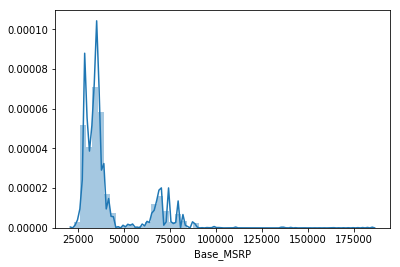

In [15]:
# price is not normally distributed
sns.distplot(df['Base_MSRP'])
plt.show()

DescribeResult(nobs=53718, minmax=(22995, 184400), mean=41198.07764622659, variance=273701035.3903445, skewness=1.8865797218735487, kurtosis=4.139163955103861)


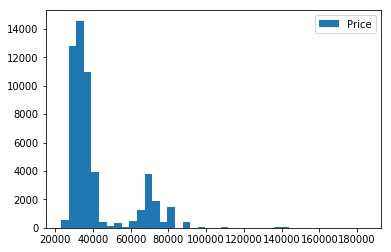

In [16]:
# price is not normally distributed
# skew may be within normal limits but kurtosis is greater than 3

plt.hist(df['Base_MSRP'], bins=40, label = 'Price')
plt.legend(loc="upper right")
print(stats.describe(df['Base_MSRP']))
plt.show()

DescribeResult(nobs=43677, minmax=(22995, 110950), mean=41850.57055200678, variance=267028578.44426793, skewness=1.4700325933859857, kurtosis=0.7494546546642358)


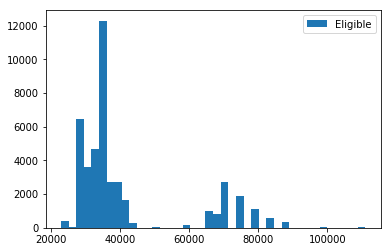

In [17]:
# creating histgrams of eligible and not eligible EVs to look at distribution
# eligible EVs is not normally distributed but skew and kurtosis are within normal limits to do a ttest

plt.hist(eligible_yes['Base_MSRP'], bins=40, label = 'Eligible')
plt.legend(loc="upper right")
print(stats.describe(eligible_yes['Base_MSRP']))
plt.show()

DescribeResult(nobs=10041, minmax=(24950, 184400), mean=38359.82123294492, variance=292846184.8808878, skewness=3.600416884677168, kurtosis=18.14456937970147)


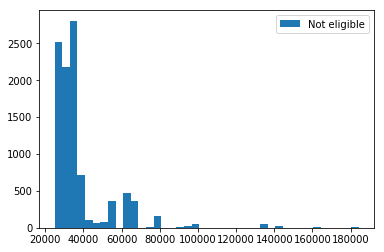

In [18]:
# EVs not eligible are not normally distributed
# both skew and kurtosis are high and greater than 3 so a ttest may not reveal dependable results

plt.hist(eligible_no['Base_MSRP'], bins=40, label = 'Not eligible')
plt.legend(loc="upper right")
print(stats.describe(eligible_no['Base_MSRP']))
plt.show()

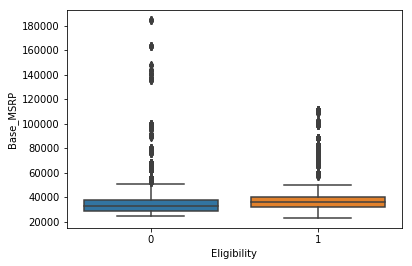

In [19]:
# boxplot reveals a lot of outliers in price especially for EVs not eligible
# is it a good idea to remove EV costing over $120k?
# log transform using y=np.log(df['Base_MSRP']) did not improve normality

sns.boxplot(x='Eligibility', y='Base_MSRP', data=df)
plt.show()

C:\Users\Mike\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


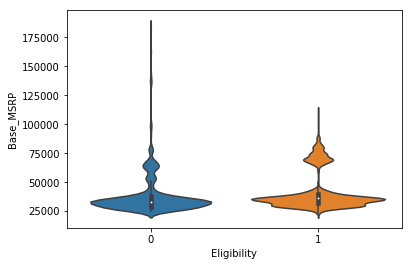

In [20]:
# violin plot reveals a midrange gap in price for both EVs that qualify for tax exemptions and those that don't
# EVs that are eligible for tax exemptions have a bigger gap in price. 
# perhaps we might look at whether standard EVs or luxury EVs qualify for tax exemptions

sns.violinplot(x='Eligibility', y='Base_MSRP', data=df)
plt.show()

Means are not great to compare on using visuals

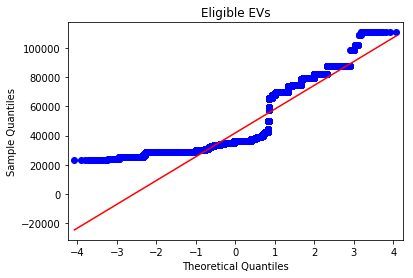

In [21]:
# checking eligiblity normality with QQ plots
# normality assumption is not valid

sm.qqplot(eligible_yes['Base_MSRP'], line='s')
plt.title('Eligible EVs')
plt.show()

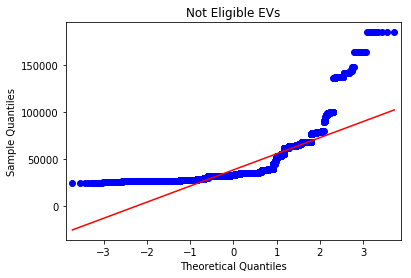

In [22]:
# checking not eligiblity normality with QQ plots
# normality assumption is not valid

sm.qqplot(eligible_no['Base_MSRP'], line='s')
plt.title('Not Eligible EVs')
plt.show()

In [23]:
t, p = stats.ttest_ind(eligible_yes['Base_MSRP'], eligible_no['Base_MSRP'])
t, p

(19.12959031611971, 2.672079461994221e-81)

In [24]:
p< 0.05

True

We need a nonparametric t-test for two independent samples. Wilcoxon Rank Sum Test or Kruskal-Wallis or the Mann-Whitney?
M-W is used when measurements are independent, samples have equal variances and > 20 per sample, 
OR normality of the population of every sample is verified OR assumed. Tests if price is different based on rank instead of mean.

Neither the independent variables or price are normally distributed and are positively skewed. A ttest ran on this data revealed a significant difference but results are not dependable. We'll run a Mann-Whitney test on the data because we only have two independent variables with similar but nonparametric distributions. We'll look for differences by medians rather than means.

* $H_0$: Median price between eligible and not eligible vehicles are the same.
* $H_a$: Median price between eligible and not eligible vehicles are significantly different.

In [25]:
# creating a new list of booleans of vehicles by eligibility
# required for Mann-Whitneytest using PyNonpar package
# scipy package for Mann-Whitney does not return a z value which we may need if sig

price_eligible = df['Eligibility'] == 1

price_noneligible = df['Eligibility'] == 0
price_noneligible.head()

1    False
3    False
4    False
5     True
6    False
Name: Eligibility, dtype: bool

In [26]:
# creating a new list of price for Mann-Whitney test using PyNonpar package

price = df['Base_MSRP']
price.value_counts()

36000     6098
35000     3924
29010     3150
29990     2830
69900     2619
28800     2062
37495     1728
33220     1362
39145     1349
30680      983
66000      977
42400      937
36620      936
79500      856
27100      832
68000      824
74500      810
32780      802
28980      722
33400      721
39995      653
34185      649
32000      648
74000      645
35200      639
34600      624
27300      621
34095      613
31770      605
38500      600
          ... 
75095       14
23800       14
35390       14
135700      12
96100       12
24950       12
43700       11
63650       11
90700       10
184400      10
36090       10
49990        9
28000        9
57400        9
29500        9
53400        8
109000       7
47900        7
39780        7
65550        6
143400       6
95650        5
89100        4
147500       4
30315        3
91250        3
94400        2
45490        1
37510        1
46400        1
Name: Base_MSRP, Length: 146, dtype: int64

In [29]:
# grouping Base_MSRP and Eligiblity for Mann-Whitney test

sample1 = price[price_eligible]
sample2 = price[price_noneligible]

In [47]:
sample1.describe().median()

37997.5

In [50]:
sample2.describe().median()

30810.0

In [42]:
U, p =stats.mannwhitneyu(sample1, sample2)
U,p
# results (160930993.0, 0.0)

(160930993.0, 0.0)

Using a Mann-Whitney U test reveals a p-value = or less than 0.  We can reject the null hypothesis and accept the alternative hypothesis that there is a significan difference in the median price between vehicles that are eligible for the sales tax exemption in Washington state and vehicles that are not.  

To determine how different they are, we will get a confidence interal using a bootstrap method to report a more meaningful range of difference. 

In [43]:
# code to bootstrap a CI from my two samples

med_diffs = []

for i in range(10000):
    eligible = sample1.sample(frac=1.0, replace=True)
    noneligible = sample2.sample(frac=1.0, replace=True)

    med_diff = eligible.median() - noneligible.median()
    med_diffs.append(med_diff)

In [44]:
ci_lo = np.percentile(med_diffs, 2.5)

In [45]:
ci_hi = np.percentile(med_diffs, 97.5)

In [46]:
# eligible is bigger median 2,600 to 2,880

(ci_lo, ci_hi)

(2600.0, 2880.0)

Because we subtracted noneligible vehicle median price from eligible vehicle price, positive numbers in our CI results indicate that eligible vehicles have a higher median price than noneligible vehicles. We can report with 95% confidence that vehicles that do qualify the Washington state sales tax exemptions have a higher median MSRP anywhere from 2,600 to 2,880 dollars.

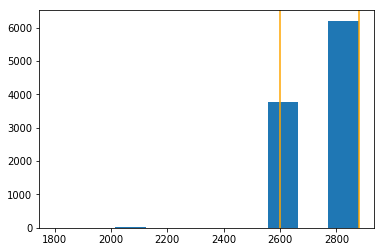

In [36]:
plt.hist(med_diffs)
plt.axvline(ci_lo, c="orange")
plt.axvline(ci_hi, c="orange")
plt.show()

In Washington state, an EV that travels 30 miles or more on battery power along qualifys for a sales tax exemption. The current sales tax rate for the state is 6.8 percent. Buyers of an EV that happens to cost 25,000 dollars would save about 1,750 dollars. 

Based on our results, it's more likely that electric vehicles that cost 2,600 to 2,880 dollars more tend to qualify for a sales tax exemption in the state of Washington. We might conclude that luxury car buyers are not influenced by a sales tax exemption. To further add weight to this finding, we could isolate other variables in the data such as grouping by standard EVs and luxury EVs. This finding suggests sales tax exemptions are more likely to apply to luxury EVs and that, as the price of an EV goes up, the buyer is less likely to care about a sales tax exemption. While this might be intuitive, lawmakers and automakers might want to have a clear differentiating price point to help drive sales or to support changes to tax laws.